In [1]:
import numpy as np
import json 
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.cluster import DBSCAN
import glob

In [2]:
def read_json(filename):
    with open(filename) as f:
        ink = json.load(f)

    return ink

In [3]:
def segment_lines(ink):
    X = np.swapaxes(np.array([ink["x"], ink["y"], ink["t"]]), 0 , 1)

    scaler = StandardScaler().fit(X)

    # X_norm = normalize(X, axis=0)
    X_scaled = scaler.transform(X)

    clustering = DBSCAN(eps=0.6, min_samples=5).fit(X_scaled)
    labels = clustering.labels_

    u_labels = np.unique(clustering.labels_)

    for i in u_labels:
        plt.scatter(X_scaled[labels == i , 0] , X_scaled[labels == i , 1] , label = i, s = 1)
    plt.legend()
    plt.gca().invert_yaxis()
    plt.show()

    textLines = []

    for label in u_labels:
        textLine = {} 
        textLine["x"] = np.array(np.array(ink["x"])[labels == label])
        textLine["y"] = np.array(np.array(ink["y"])[labels == label])
        textLine["t"] = np.array(np.array(ink["t"])[labels == label])
        textLine["p"] = np.array(np.array(ink["p"])[labels == label])

        textLines.append(textLine)

    return textLines

In [4]:
def splice_lines_together(textLines):
    merged_textLine = {}
    merged_textLine["x"] = textLines[0]["x"]
    merged_textLine["y"] = textLines[0]["y"]
    merged_textLine["t"] = textLines[0]["t"]
    merged_textLine["p"] = textLines[0]["p"]

    # Determine the y-mean and x-last of the first line 
    x_right_last = np.max(textLines[0]["x"])
    y_mean_1 = np.mean(textLines[0]["y"])

    # For each line after the first 
    for i in range(1, len(textLines)):
        textLine = textLines[i]

        # Get the x-start and y_mean of the new line 
        # x_left_curr = np.max(textLine["x"])
        y_mean_curr = np.mean(textLine["y"])
        
        # Add x_right_last to all x values of the next line
        x = textLine["x"]
        x_left_first = np.min(x)
        x_new = x + (x_right_last - x_left_first)
        
        x_right_last = np.max(x_new)
        
        # Minus the difference of means to y values 
        y = textLine["y"]
        y_new = y - y_mean_curr + y_mean_1 
        
        merged_textLine["x"] = np.append(merged_textLine["x"], x_new)
        merged_textLine["y"] = np.append(merged_textLine["y"], y_new)
        merged_textLine["t"] = np.append(merged_textLine["t"], textLine["t"])
        merged_textLine["p"] = np.append(merged_textLine["p"], textLine["p"])
        
    # plt.figure(figsize=(20,5))
    # plt.plot(merged_textLine["x"], merged_textLine["y"])
    # plt.gca().invert_yaxis()
    # plt.show()

    return merged_textLine

In [5]:
def create_evenly_spaced_series(merged_textline):
    x = merged_textline["x"]
    y = merged_textline["y"]
    t = merged_textline["t"]
    p = merged_textline["p"]

    start_t = t[0]
    end_t = t[len(t) - 1]

    t_filled = np.arange(start_t, end_t, 13)
    x_filled = np.interp(t_filled, t, x)
    y_filled = np.interp(t_filled, t, y)
    p_filled = np.interp(t_filled, t, p)

    merged_textline["x"] = x_filled
    merged_textline["y"] = y_filled
    merged_textline["t"] = t_filled
    merged_textline["p"] = p_filled

    return merged_textline

In [6]:
def normalise_textLine(textLine):
    X = np.swapaxes(np.array([textLine["x"], textLine["y"], textLine["t"], textLine["p"]]), 0 , 1)

    scaler = StandardScaler().fit(X)

    # X_norm = normalize(X, axis=0)
    X_scaled = scaler.transform(X)

    textLine["x"] = X_scaled[:, 0]
    textLine["y"] = X_scaled[:, 1]
    textLine["t"] = X_scaled[:, 2]
    textLine["p"] = X_scaled[:, 3]
    return textLine

In [7]:
def format_ink(filename):
    ink = read_json(filename)

    textLines = segment_lines(ink)
    merged_textLine = splice_lines_together(textLines)
    merged_textLine = create_evenly_spaced_series(merged_textLine)
    digital_ink = normalise_textLine(merged_textLine)
    return digital_ink

Formatting and saving 8Z8Zk6qnS4S74FIpjs3l


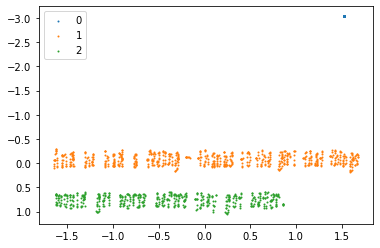

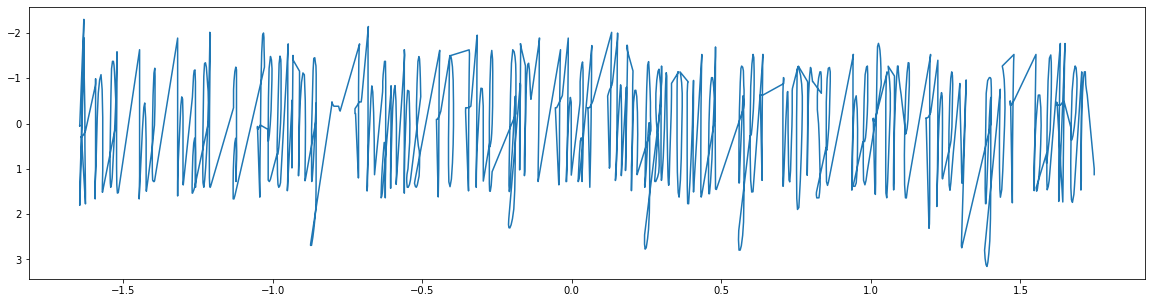

Formatting and saving 4DEx1UITVvHf7r8utD9Z


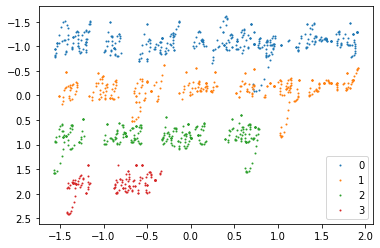

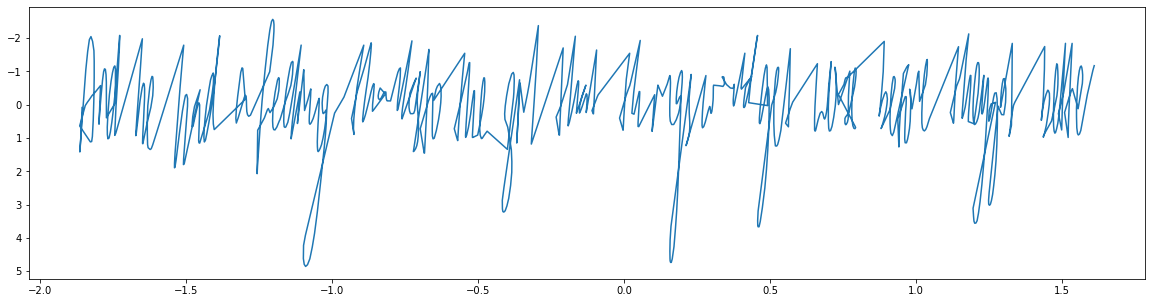

Formatting and saving 8e05bbCJrJlptvjGm1xa


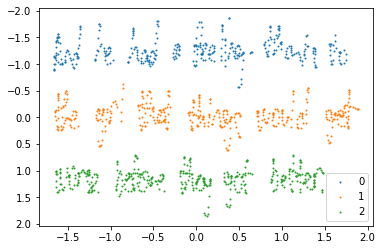

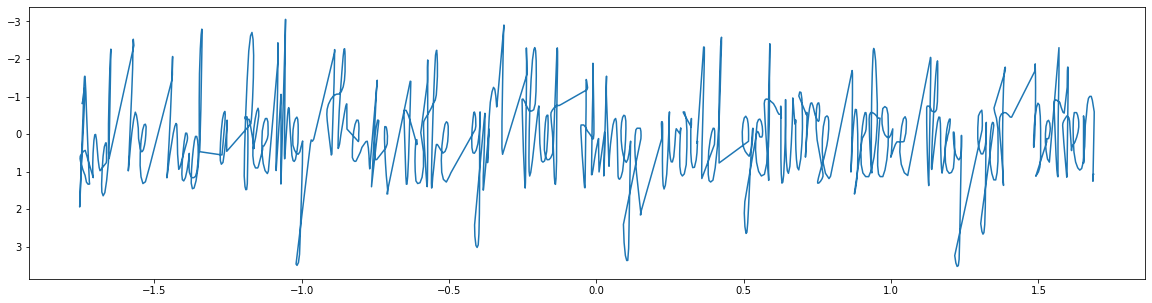

Formatting and saving pwzrwYnnyBRiJaBuWCvZ


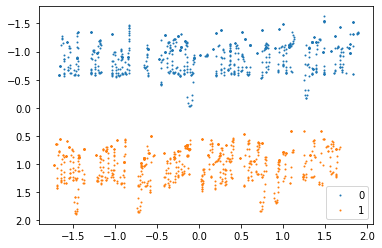

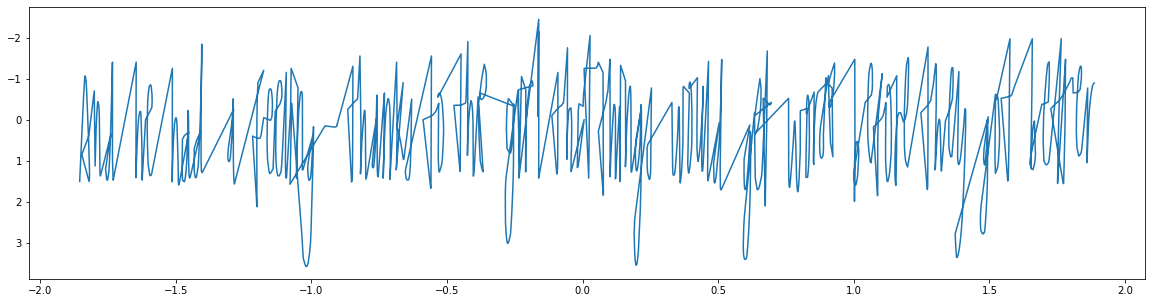

Formatting and saving 2x7KWpGxDjsH40bJvsP7


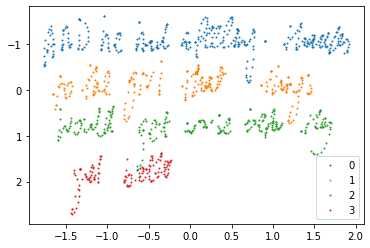

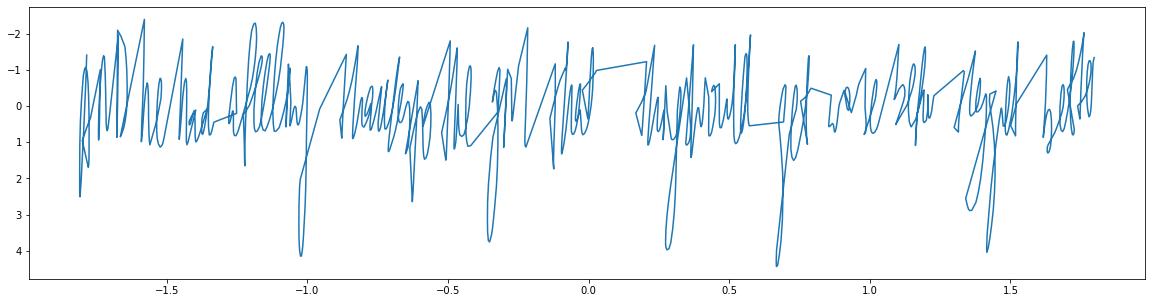

Formatting and saving QVsCfGYE28LsGxDa1417


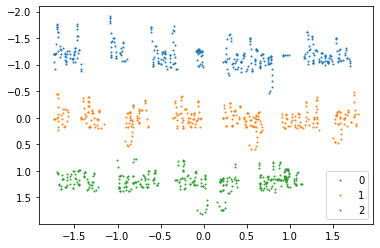

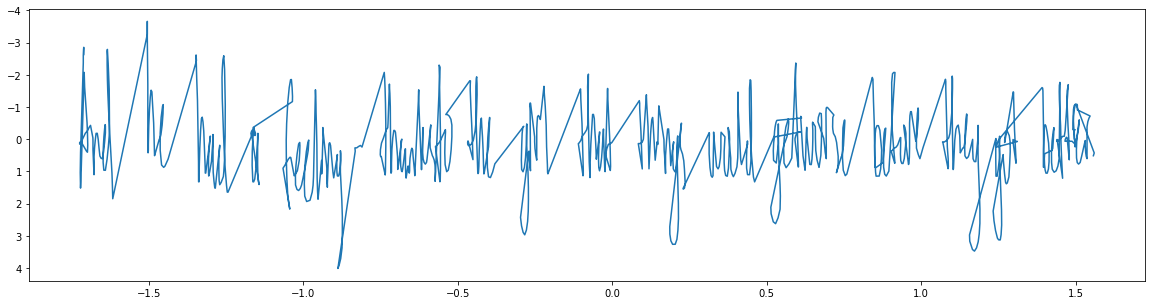

Formatting and saving UJmJnIqlwsNEFfjKelTN


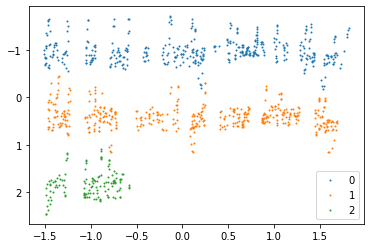

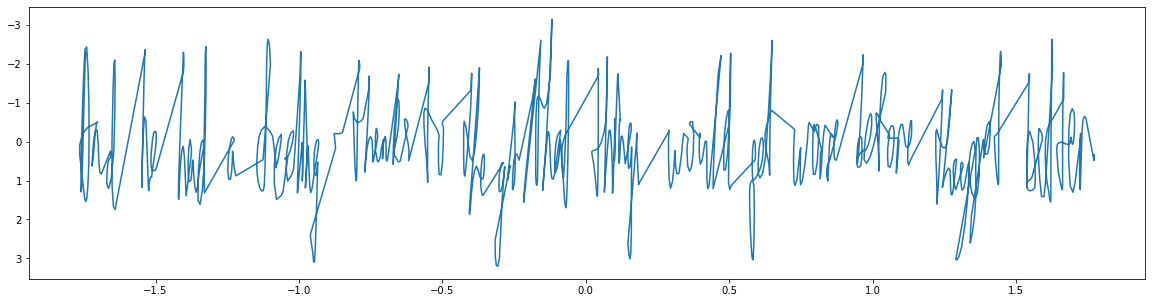

Formatting and saving oIH1HmVVxrJVAXRbwjxk


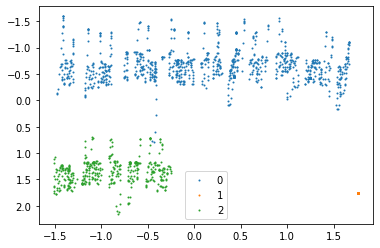

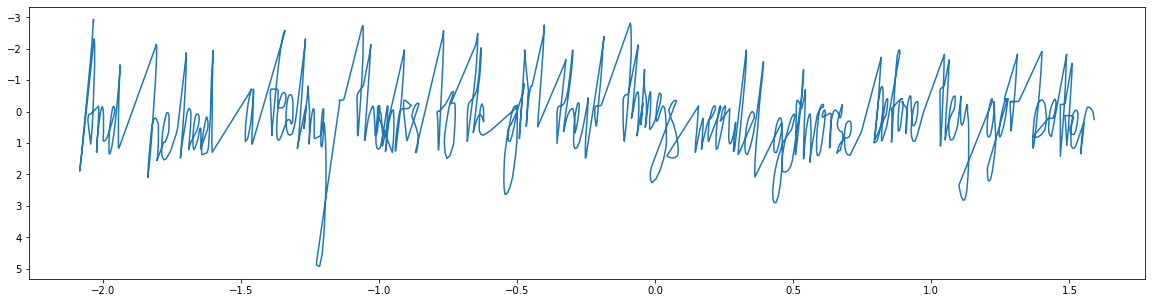

Formatting and saving i7pJPDAihjRnN4VGZNKG


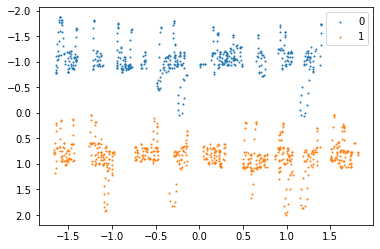

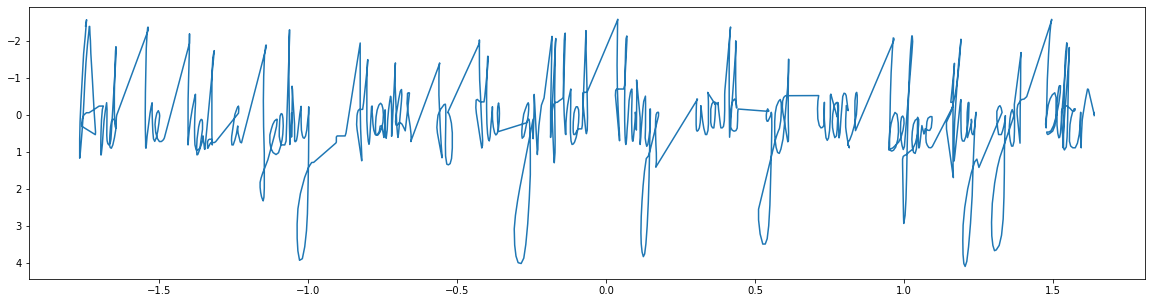

Formatting and saving lbk43HuL5voOJI49qHRm


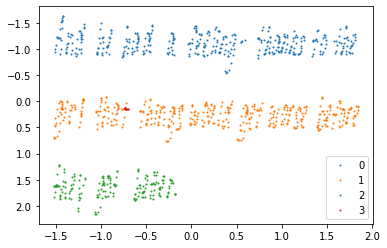

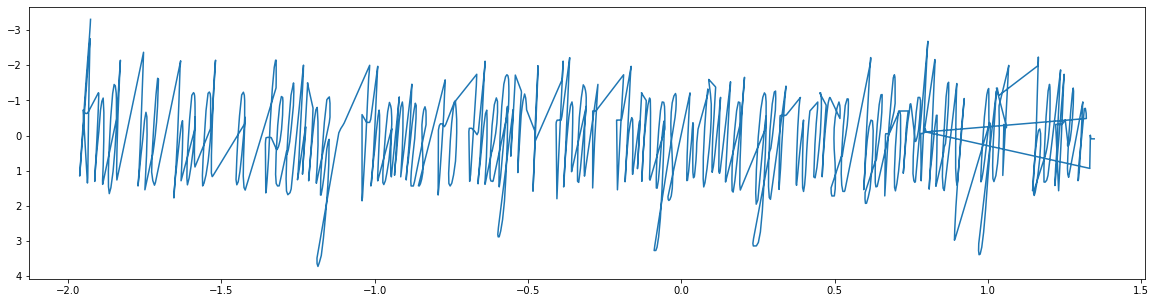

Formatting and saving L1l3xQZg4erNtCnqpgDX


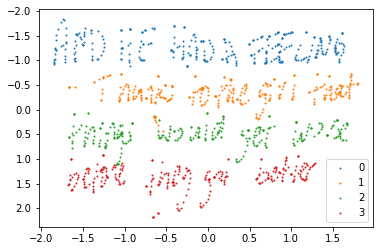

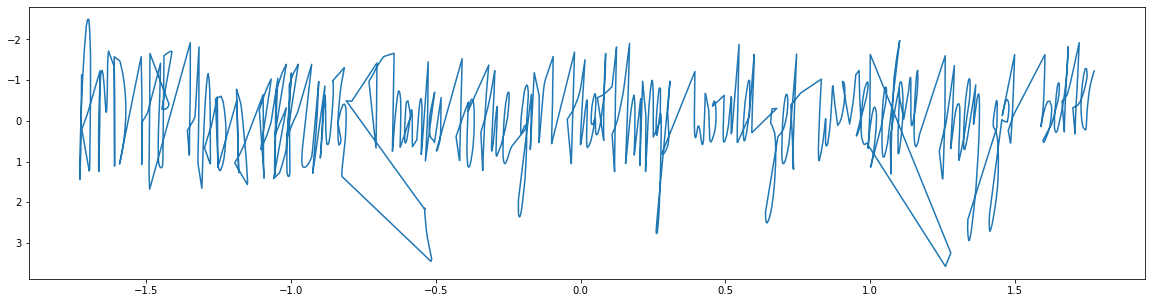

Formatting and saving UpjeWjdH7HrpzNvAOnZE


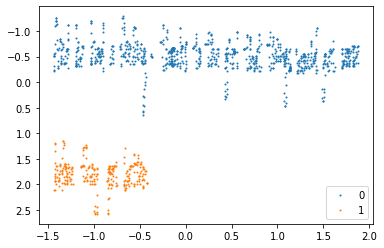

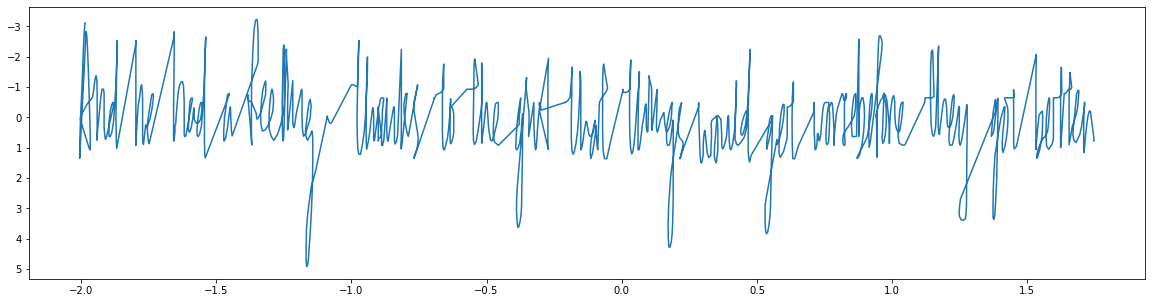

Formatting and saving eWYRgAeE4psads07EGIm


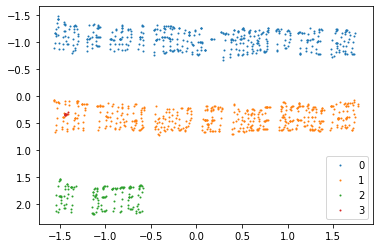

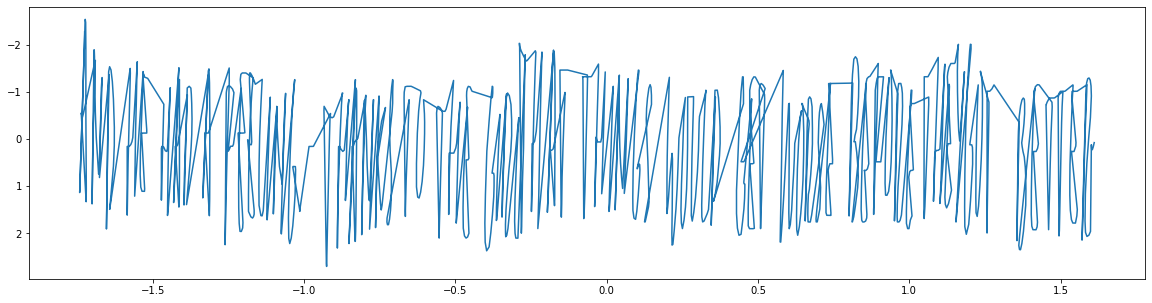

Formatting and saving wHbt2fWqZGeUgdc54FEG


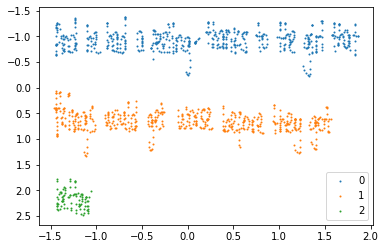

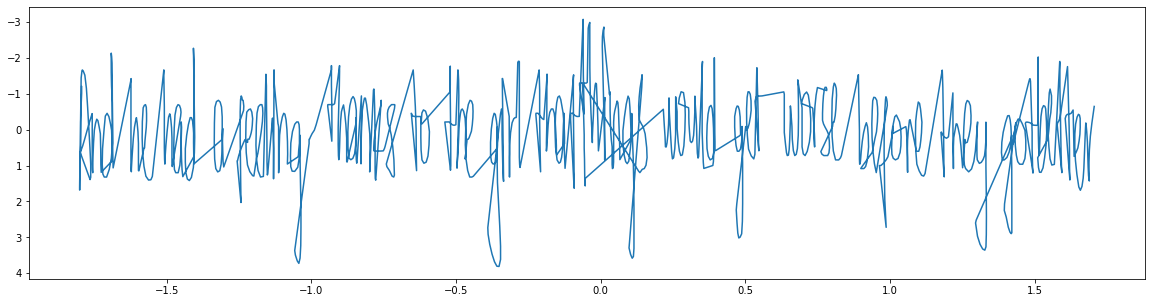

Formatting and saving PyPGAyhjuH5OleamLqs7


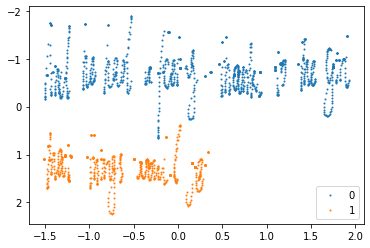

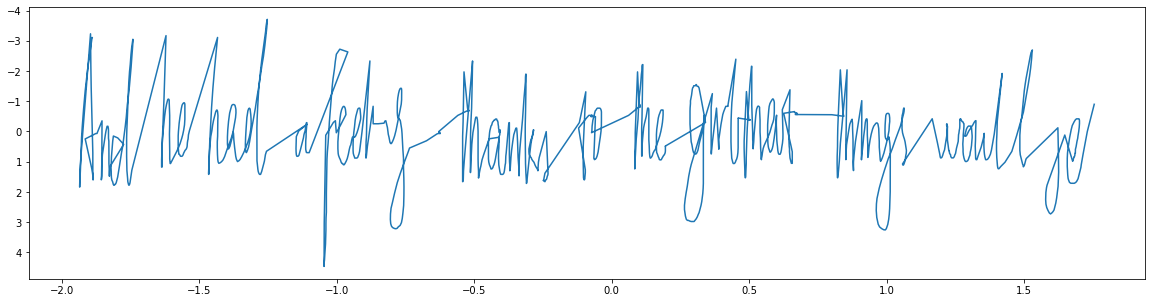

In [10]:
# Test out function 
for f in glob.glob("../data/uploaded_ink/*"):
    filename = f.split("/")[3].split(".")[0]
    print(f'Formatting and saving {filename}')
    
    digital_ink = format_ink(f)

    # Make numpy arrays json serialisable
    digital_ink["x"] = digital_ink["x"].tolist()
    digital_ink["y"] = digital_ink["y"].tolist()
    digital_ink["t"] = digital_ink["t"].tolist()
    digital_ink["p"] = digital_ink["p"].tolist()

    # print(digital_ink)

    # plt.figure(figsize=(20,5))
    # plt.plot(digital_ink["x"], digital_ink["y"])
    # plt.gca().invert_yaxis()
    # plt.show()

    # save_target = "../data/formatted_ink/" + filename + ".json"

    # with open(save_target, 'w') as fp:
    #     json.dump(digital_ink, fp)

